In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [2]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.utils import to_dense_batch, to_dense_adj, k_hop_subgraph, to_networkx
import torch
import jax
import numpy as np
import jax.numpy as jnp
import tensorcircuit as tc
from tqdm import tqdm
from time import time
from itertools import zip_longest

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

Please first ``pip install -U cirq`` to enable related functionality in translation module


0.10.0


In [3]:
jax.devices()

2023-09-06 20:08:31.088850: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

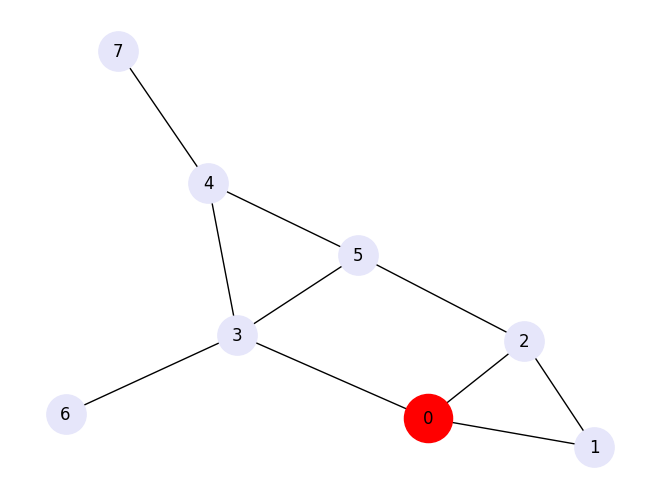

In [4]:
# import networkx for graph generation
import networkx as nx

# import matplotlib library
import matplotlib.pyplot as plt

# generation of a sample graph
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (4, 5), (3, 4), (0, 3), (3, 6),
                  (2, 5), (3, 5), (4, 7)])

# Defining ego as large and red
# while alters are in lavender
# Let 'A' be the ego
ego = 0
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="lavender", node_size=800, with_labels=True)

options = {"node_size": 1200, "node_color": "r"}
nx.draw_networkx_nodes(G, pos, nodelist=[ego], **options)
plt.show()

In [5]:
DATASET_PATH = "./data"
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH,
                                                name="MUTAG")
tu_dataset.shuffle()

MUTAG(188)

In [6]:
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     17.9 |     39.6 |
| std        |      4.6 |     11.4 |
| min        |     10   |     20   |
| quantile25 |     14   |     28   |
| median     |     17   |     38   |
| quantile75 |     22   |     50   |
| max        |     28   |     66   |
+------------+----------+----------+

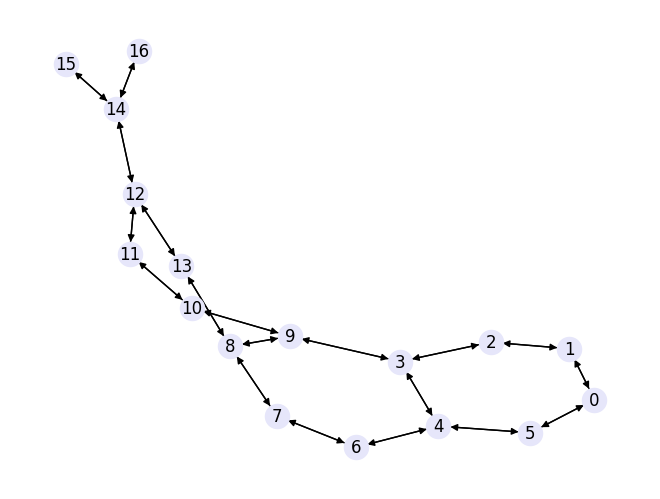

In [7]:
data = tu_dataset[0]
nxgraph = to_networkx(data)
nx.draw(nxgraph, with_labels=True, node_color="lavender")

In [8]:
import torch_geometric.transforms as T

transform = T.Compose([T.Pad(28, 66)])
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH,
                                                name="MUTAG",
                                                transform=transform)
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       28 |       66 |
| std        |        0 |        0 |
| min        |       28 |       66 |
| quantile25 |       28 |       66 |
| median     |       28 |       66 |
| quantile75 |       28 |       66 |
| max        |       28 |       66 |
+------------+----------+----------+

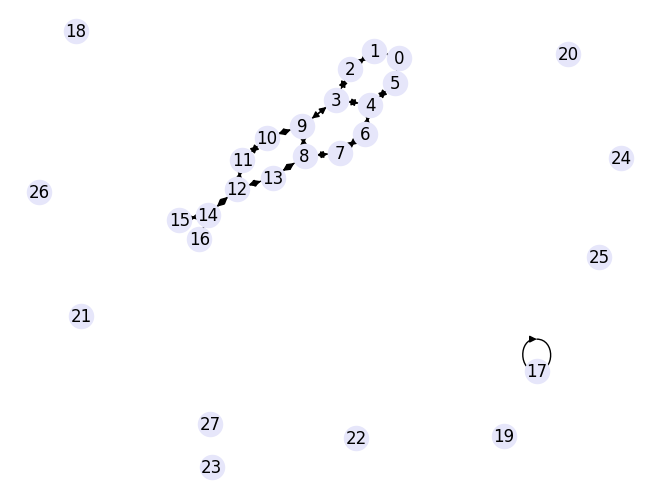

In [9]:
data = tu_dataset[0]
nxgraph = to_networkx(data)
nx.draw(nxgraph, with_labels=True, node_color="lavender")

In [10]:
k = 3
max_nodes = 28

In [11]:
temp_dataset = []

max_ego_nodes = 0

for data in tu_dataset:
    n_nodes = data.num_nodes
    
    ego_nodes = []
    for node in range(n_nodes):
        
        try:
            subset, edge_index, _, _ = k_hop_subgraph(node,
                                                  k,
                                                  data.edge_index,
                                                  directed=False)
        except:
            subset = []
            edge_index = torch.tensor([])
            
        n_subset_nodes = len(subset)
    
        if n_subset_nodes:
            G = nx.Graph()
            G.add_edges_from(edge_index.numpy().T)
            paths = nx.single_source_shortest_path_length(G, node, cutoff=k)

            nodes = np.array(list(paths.keys()))
            dists = np.array(list(paths.values()))
            dists[0] = 1

            hop_nodes = [
                list(nodes[np.where(dists == hop)[0]]) for hop in range(1, k + 1)
            ]
            
            hop_nodes = np.array(list(zip_longest(*hop_nodes, fillvalue=max_nodes+1))).T
        else:
            dists = np.array([])
            hop_nodes = np.array([np.array([])]*k)
            
        ego_nodes.append(hop_nodes)

        max_ego_nodes = max(max_ego_nodes, hop_nodes.shape[-1])

    temp_dataset.append(ego_nodes)

In [12]:
ego_dataset = np.stack([np.stack([
        np.pad(ego_nodes, ((0, 0), (0, max_ego_nodes - ego_nodes.shape[-1])),
               constant_values=max_nodes+1) for ego_nodes in data
    ]) for data in temp_dataset]).astype(np.int32)

In [13]:
ego_dataset.shape

(188, 28, 3, 8)

In [14]:
from torch.utils.data import Dataset

class MUTAGDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self):
        pass
    
    def __len__(self):
        return len(tu_dataset)

    def __getitem__(self, idx):
        data = tu_dataset[idx]
        return {
            'x': data.x,
            'ego_graphs': torch.tensor(ego_dataset[idx]),
            'y': data.y
        }

In [15]:
import ml_collections

def get_config():
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()

    config.learning_rate = 0.01
    config.batch_size = 4
    config.num_epochs = 10
    
    return config

In [35]:
from flax.training import train_state

def create_train_state(rng, config):
    """Creates initial `TrainState`."""
    qgnn = GraphQ()
    params = qgnn.init(rng, jnp.ones([28, 7]),
                       jnp.ones([28, k, 8]).astype(jnp.int32))['params']
    tx = optax.adam(config.learning_rate)
    return train_state.TrainState.create(apply_fn=qgnn.apply,
                                         params=params,
                                         tx=tx)

In [36]:
from torch.utils.data import random_split, DataLoader

def my_collate_fn(batch):
    x = []
    y = []
    ego_graphs = []
    for data in batch:
        x += [data['x']]
        y += [data['y']]
        ego_graphs += [data['ego_graphs']]
    
    x = torch.stack(x)
    y = torch.stack(y)
    ego_graphs = torch.stack(ego_graphs)
    return x, y, ego_graphs


def get_loaders(config):
    split = 145
    mutag_ds = MUTAGDataset()

    split_a_size = split
    split_b_size = len(mutag_ds) - split_a_size

    train_dataset, test_dataset = random_split(
        mutag_ds, [split_a_size, split_b_size],
        generator=torch.Generator().manual_seed(42))

    batch_size = config.batch_size
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=my_collate_fn,
                              num_workers=8)

    val_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=my_collate_fn,
                            num_workers=8)
    
    return train_loader, val_loader

In [37]:
from flax import linen as nn
import optax
from typing import Callable


def graph_circ(ego_graphs, x, lmbd, theta):
#     print('incirc', x.shape, ego_graphs.shape, lmbd.shape, theta.shape)
    n_qubits = ego_graphs.shape[-1]
    n_features = x.shape[-1]
    n_hops = ego_graphs.shape[-2]
    steps = n_features // 3
    c = tc.Circuit(n_qubits)

    for hop in range(n_hops):
        inputs = jnp.take(x, ego_graphs[hop], axis=0)
        inputs = jnp.nan_to_num(inputs)
        inputs = jnp.multiply(inputs, lmbd[hop])        
        
        for q in range(n_qubits):
            for i in range(steps):
                c.rx(q, theta=inputs[q, 3*i])
                c.ry(q, theta=inputs[q, 3*i + 1])
                c.rz(q, theta=inputs[q, 3*i + 2])
            
            c.rx(q, theta=theta[hop, q, 0])
            c.ry(q, theta=theta[hop, q, 1])
            c.rz(q, theta=theta[hop, q, 2])
            
        for q in range(n_qubits - 1):
            c.cnot(i, i + 1)
            
    return K.real(jnp.array([c.expectation_ps(z=[i]) for i in range(n_qubits)]))
    
qpred_vmap = K.vmap(K.jit(graph_circ), vectorized_argnums=(0, ))

def qnn(x, ego_graphs, lmbd, theta):
    return qpred_vmap(ego_graphs, x, lmbd, theta)

qnn_vmap =  K.vmap(K.jit(qnn), vectorized_argnums=(0, 1))

class GraphQ(nn.Module):
    """A simple CNN model."""
    wb_init: Callable = nn.initializers.uniform()

    @nn.compact
    def __call__(self, x, ego_graphs):
#         print('inside graphq', x.shape, ego_graphs.shape)

        n_qubits = ego_graphs.shape[-1]
        n_features = x.shape[-1]
        n_hops = ego_graphs.shape[-2]

        lmbd = self.param('λ', self.wb_init, (n_hops, n_qubits, n_features))
        theta = self.param('θ', self.wb_init, (n_hops, n_qubits, 3))

        res = qnn_vmap(x, ego_graphs, lmbd, theta)
        res = jnp.mean(res, axis=1)
        res = nn.Dense(features=2)(res)
        return res

In [38]:
def loss_fn(params, x, y, ego_graphs):
    logits = state.apply_fn({'params': params}, x, ego_graphs)
    one_hot = jax.nn.one_hot(y, 2)
    print(one_hot.shape, logits.reshape(1, -1).shape)
    loss = jnp.mean(
        optax.softmax_cross_entropy(logits=logits.reshape(1, -1), labels=one_hot))
    return loss, logits

In [39]:
qml_vvag = K.vectorized_value_and_grad(
    loss_fn, argnums=(0,), vectorized_argnums=(1, 2, 3), has_aux=True
)
qml_vvag = K.jit(qml_vvag)

In [40]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

@jax.jit
def apply_model(state, x, y, ego_graphs):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params, x, y, ego_graphs: jnp.array):
        logits = state.apply_fn({'params': params}, x, ego_graphs)
        one_hot = jax.nn.one_hot(y.reshape(-1, ), 2)
#         print('inside loss', one_hot.shape, logits.shape)
        loss = jnp.mean(
            optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, x, y, ego_graphs)
    
    accuracy = jnp.mean(jnp.argmax(logits, -1) == y)
    return grads, loss, accuracy

def evaluate(state, loader):
    eval_loss = []
    eval_accuracy = []
    
    with tqdm(loader, unit="batch") as tepoch:
        for x, y, ego_graphs in tepoch:
            tepoch.set_description("Val")
            _, loss, accuracy = apply_model(
                state, x.numpy(), y.numpy(),
                ego_graphs.numpy().astype(np.int32))
            eval_loss.append(loss)
            eval_accuracy.append(accuracy)
        eval_loss = np.mean(eval_loss)
        eval_accuracy = np.mean(eval_accuracy)
        
    return eval_loss, eval_accuracy

def train_epoch(state, loader, epoch):
    """Train for a single epoch."""
    epoch_loss = []
    epoch_accuracy = []

    with tqdm(loader, unit='batch') as tepoch:
        for x, y, ego_graphs in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            grads, loss, accuracy = apply_model(
                state, x.numpy(), y.numpy(),
                ego_graphs.numpy().astype(np.int32))
    
            
            state = update_model(state, grads)
            epoch_loss.append(loss)
            epoch_accuracy.append(accuracy)
        train_loss = np.mean(epoch_loss)
        train_accuracy = np.mean(epoch_accuracy)

    return state, train_loss, train_accuracy

In [41]:
config = get_config()
train_loader, val_loader = get_loaders(config)
rng = jax.random.PRNGKey(0)

rng, init_rng = jax.random.split(rng)
state = create_train_state(init_rng, config)

inside graphq (28, 7) (28, 3, 8)


In [42]:
for epoch in range(1, config.num_epochs + 1):

    state, train_loss, train_accuracy = train_epoch(
        state, train_loader, epoch)

    test_loss, test_accuracy = evaluate(state, val_loader)

    print(
        f'epoch: {epoch:3d}',
        f'train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}',
        f'test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}')

Epoch 1:   0%|                                        | 0/37 [00:00<?, ?batch/s]

inside graphq (28, 7) (28, 3, 8)
(1, 2) (2,)


Epoch 1:   0%|                                        | 0/37 [00:57<?, ?batch/s]


ValueError: Expected tuple, got FrozenDict({
    Dense_0: {
        bias: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>,
        kernel: Traced<ShapedArray(float32[8,2])>with<DynamicJaxprTrace(level=1/0)>,
    },
    θ: Traced<ShapedArray(float32[3,8,3])>with<DynamicJaxprTrace(level=1/0)>,
    λ: Traced<ShapedArray(float32[3,8,7])>with<DynamicJaxprTrace(level=1/0)>,
}).